In [ ]:
!pip install torch transformers numpy scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

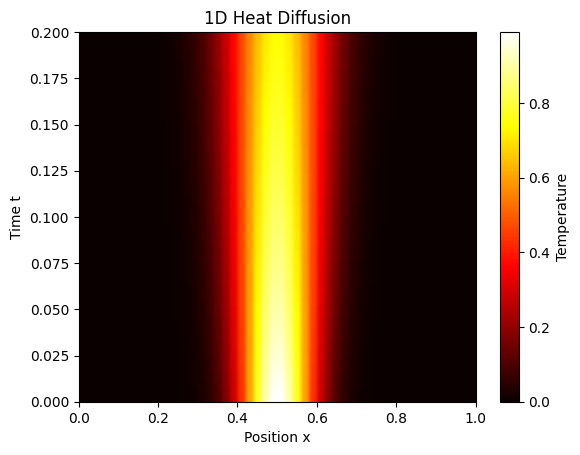

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define PDE: Heat Equation ∂u/∂t = α ∂²u/∂x²
alpha = 0.01  # Thermal diffusivity
L = 1.0       # Length of domain
Nx = 50       # Number of spatial points
Nt = 200      # Number of time steps
dx = L / Nx
dt = 0.001

x = np.linspace(0, L, Nx)
t = np.linspace(0, Nt * dt, Nt)

# Initial Condition: Gaussian Pulse
u0 = np.exp(-100 * (x - 0.5)**2)

# Define Finite Difference Solver
def heat_eq(t, u):
    dudt = np.zeros_like(u)
    dudt[1:-1] = alpha * (u[:-2] - 2 * u[1:-1] + u[2:]) / dx**2
    return dudt

sol = solve_ivp(heat_eq, [0, Nt * dt], u0, t_eval=t, method='RK45')
U = sol.y.T  # Solution Matrix U(x, t)

# Plot solution
plt.imshow(U, aspect='auto', extent=[0, L, 0, Nt * dt], origin='lower', cmap="hot")
plt.colorbar(label="Temperature")
plt.xlabel("Position x")
plt.ylabel("Time t")
plt.title("1D Heat Diffusion")
plt.show()


In [ ]:
U.shape

(200, 50)

In [ ]:
U[10,:].shape

(50,)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Transformer-based model for function approximation
class TransformerPINN(nn.Module):
    def __init__(self, d_model=128, nhead=8, num_layers=6, hidden_dim=256):
        super().__init__()
        self.embed = nn.Linear(2, d_model)  # (x, t) → d_model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, hidden_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.decoder = nn.Linear(d_model, 1)  # Output u(x,t)

    def forward(self, x):
        x = x.squeeze(-1)
        x = self.embed(x)
        x = self.transformer(x)
        return self.decoder(x).squeeze(-1)  # Output shape: (batch,)

# Instantiate model
model = TransformerPINN()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerPINN(
  (embed): Linear(in_features=2, out_features=128, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)

In [ ]:
def physics_loss(model, x, t, alpha=1.0):
    x = x.clone().detach().requires_grad_(True).to(device)
    t = t.clone().detach().requires_grad_(True).to(device)

    inputs = torch.cat([x, t], dim=1).to(device)  # Ensure correct input format
    u = model(inputs)

    # Compute first-order and second-order derivatives
    #du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u).to(device), create_graph=True, retain_graph=True)[0]
    #du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u).to(device), create_graph=True, retain_graph=True)[0]
    #d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx).to(device), create_graph=True, retain_graph=True)[0]
    # Compute first-order and second-order derivatives using finite difference approximations
    du_dx = (model(torch.cat([x + dx, t], dim=1).to(device)) - model(torch.cat([x - dx, t], dim=1).to(device))) / (2 * dx)
    du_dt = (model(torch.cat([x, t + dt], dim=1).to(device)) - model(torch.cat([x, t - dt], dim=1).to(device))) / (2 * dt)
    d2u_dx2 = (model(torch.cat([x + dx, t], dim=1).to(device)) - 2 * model(torch.cat([x, t], dim=1).to(device)) + model(torch.cat([x - dx, t], dim=1).to(device))) / (dx**2)

    residual = du_dt - alpha * d2u_dx2  # Heat Equation residual
    return torch.mean(residual**2)  # MSE loss


# Initial condition data
sigma = 0.1  # Width of the Gaussian
x_ic = torch.linspace(0, L, 50).reshape(-1, 1).to(device)  # Spatial points
t_ic = torch.zeros_like(x_ic).to(device)  # t = 0
u_ic = torch.exp(-((x_ic - L / 2) ** 2) / (2 * sigma ** 2)).to(device)  # Gaussian

# Concatenate (x, t) pairs for initial condition training
X_ic = torch.cat([x_ic, t_ic], dim=1)

# Data for training
x_train = torch.FloatTensor(np.random.rand(1000, 1) * L).to(device).requires_grad_(True)
t_train = torch.FloatTensor(np.random.rand(1000, 1) * (Nt * dt)).to(device).requires_grad_(True)
u_train = torch.FloatTensor(np.interp(x_train.cpu().detach().numpy().flatten(), x.flatten(), U[10, :])).to(device)

# Enforce initial condition strictly in loss function
def initial_loss(model, X_ic, u_ic):
    u_pred = model(X_ic)  # Predict u(x, 0)
    return torch.nn.functional.mse_loss(u_pred, u_ic)

# Supervised loss (Data loss)
def supervised_loss(model, x, t, u_true):
    u_pred = model(torch.cat([x, t], dim=1).to(device))
    return torch.nn.functional.mse_loss(u_pred, u_true.to(device))

# Training Loop
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(5000):
    optimizer.zero_grad()
    loss_pde = physics_loss(model, x_train, t_train)
    #loss_data = supervised_loss(model, x_train, t_train, u_train)
    loss_ic = initial_loss(model, X_ic, u_ic)  # Initial condition loss
    loss = loss_pde + 10*loss_ic  # Combined loss
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training Complete")


<ipython-input-5-37d515e6f822>:38: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.nn.functional.mse_loss(u_pred, u_ic)


Epoch 0, Loss: 505031.90625
Epoch 50, Loss: 43192.05859375
Epoch 100, Loss: 19695.669921875
Epoch 150, Loss: 12091.224609375
Epoch 200, Loss: 10236.8828125
Epoch 250, Loss: 8444.7080078125
Epoch 300, Loss: 6810.044921875
Epoch 350, Loss: 5125.3486328125
Epoch 400, Loss: 4572.1083984375
Epoch 450, Loss: 4315.15380859375
Epoch 500, Loss: 3373.73486328125
Epoch 550, Loss: 3277.674560546875
Epoch 600, Loss: 2938.223388671875
Epoch 650, Loss: 2833.96044921875
Epoch 700, Loss: 2214.927490234375
Epoch 750, Loss: 2119.040771484375
Epoch 800, Loss: 2044.801513671875
Epoch 850, Loss: 1874.70849609375
Epoch 900, Loss: 1672.093017578125
Epoch 950, Loss: 1537.347412109375
Epoch 1000, Loss: 1379.8427734375
Epoch 1050, Loss: 1241.7884521484375
Epoch 1100, Loss: 1215.226318359375
Epoch 1150, Loss: 1043.9473876953125
Epoch 1200, Loss: 1087.897705078125
Epoch 1250, Loss: 982.939453125
Epoch 1300, Loss: 994.0492553710938
Epoch 1350, Loss: 887.690673828125
Epoch 1400, Loss: 715.6314086914062
Epoch 1450, L

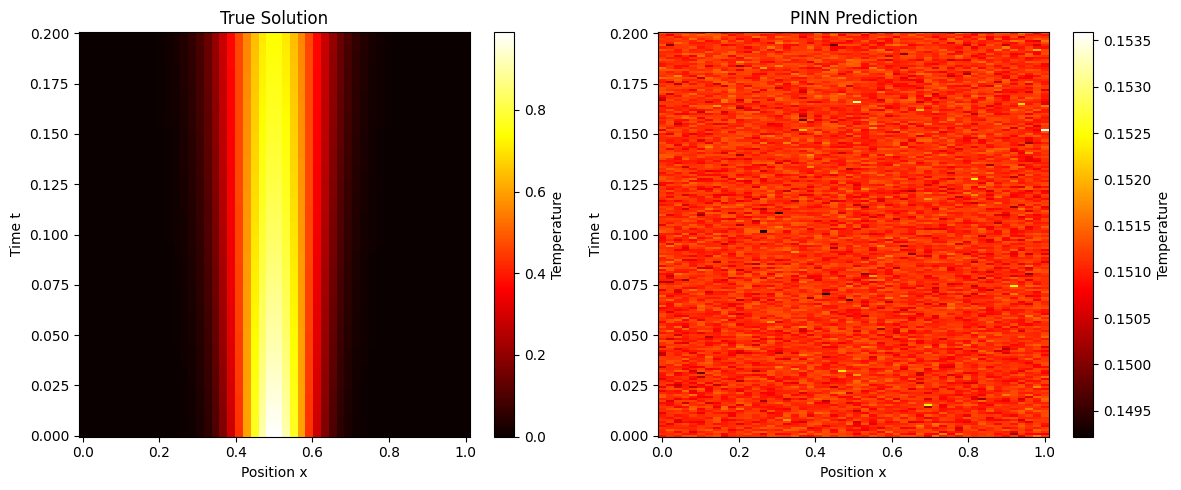

In [ ]:
# Create meshgrid for full space-time domain
X, T = np.meshgrid(x, np.linspace(0, Nt * dt, Nt))  # Shape: (Nt, Nx)

# Convert to tensors and reshape for model input
x_test = torch.FloatTensor(X.flatten()).reshape(-1, 1).to(device)
t_test = torch.FloatTensor(T.flatten()).reshape(-1, 1).to(device)

# Predict over the full domain
with torch.no_grad():
    u_pred = model(torch.cat([x_test, t_test], dim=1)).cpu().numpy().reshape(Nt, Nx)  # Reshape back

# Plot True Solution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(X, T, U, shading='auto', cmap='hot')
plt.colorbar(label="Temperature")
plt.xlabel("Position x")
plt.ylabel("Time t")
plt.title("True Solution")

# Plot PINN Prediction
plt.subplot(1, 2, 2)
plt.pcolormesh(X, T, u_pred, shading='auto', cmap='hot')
plt.colorbar(label="Temperature")
plt.xlabel("Position x")
plt.ylabel("Time t")
plt.title("PINN Prediction")

plt.tight_layout()
plt.show()

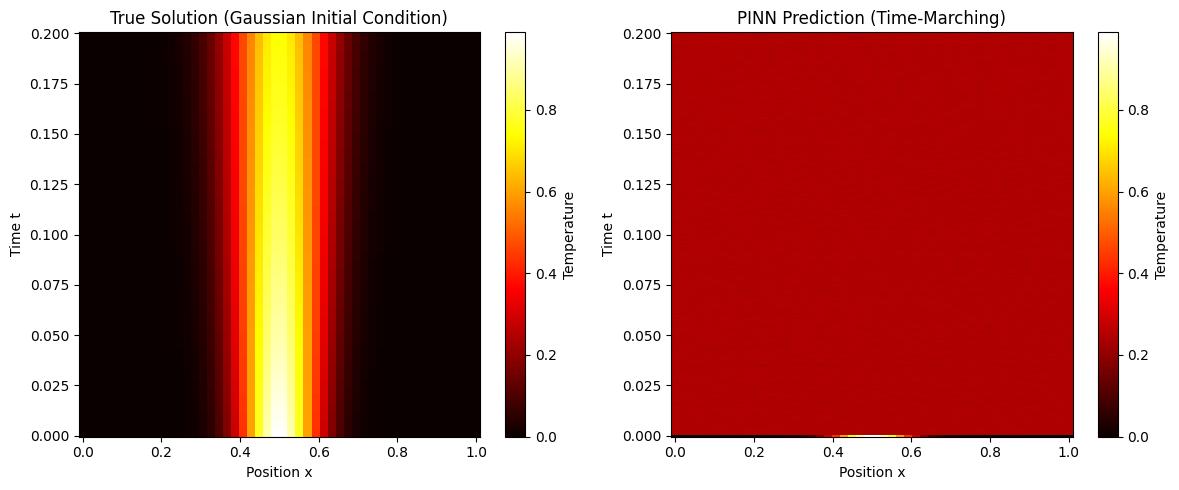

In [ ]:
# Generate spatial points
x_test = torch.FloatTensor(np.linspace(0, L, Nx)).reshape(-1, 1).to(device)

# Initialize solution storage
u_pred = np.zeros((Nt, Nx))

# Set initial condition at t=0
u_pred[0, :] = np.exp(-100 * (x_test.cpu().numpy().flatten() - L / 2) ** 2)  # Gaussian IC

# Iterate over time steps using the PINN model
for n in range(1, Nt):
    t_test = torch.full((Nx, 1), n * dt).to(device)  # Current time step
    u_pred[n, :] = model(torch.cat([x_test, t_test], dim=1)).cpu().detach().numpy().flatten()

# Create meshgrid for plotting
X_test, T_test = np.meshgrid(np.linspace(0, L, Nx), np.linspace(0, Nt * dt, Nt))

# Plot True vs. PINN Prediction
plt.figure(figsize=(12, 5))

# True Solution (Ground Truth)
plt.subplot(1, 2, 1)
plt.pcolormesh(X_test, T_test, U, shading='auto', cmap='hot')
plt.colorbar(label="Temperature")
plt.xlabel("Position x")
plt.ylabel("Time t")
plt.title("True Solution (Gaussian Initial Condition)")

# PINN Prediction (Sequential Time Evolution)
plt.subplot(1, 2, 2)
plt.pcolormesh(X_test, T_test, u_pred, shading='auto', cmap='hot')
plt.colorbar(label="Temperature")
plt.xlabel("Position x")
plt.ylabel("Time t")
plt.title("PINN Prediction (Time-Marching)")

plt.tight_layout()
plt.show()


In [ ]:
#x.shape
U[:, mid_time_index].shape

(200,)

In [ ]:
x.shape

(50,)